# Classification using VGG16

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_list = drive.ListFile({'q': "'1otOTvDuni4Rg76ryPmXciSQa8CXcskIC' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: CarPrediction.ipynb, id: 1izrvRuqohO6SNGIWoQVSRvFnkduy6pSH
title: new cars_3.zip, id: 13Du2JUMQtGbv6W9Ab2R0238epf_GxNOo
title: new new cars.zip, id: 1CzraghJaUPymHVWaUc8jhYNEuLyzQ5ty
title: new cars_3_categories.zip, id: 1rQ_iDx7CxnoRkHVB9zSzevXDX2w57k2E
title: new cars-validate.zip, id: 1bwcaOLd76ZoyL9D3EAUiEvq1tLQon9FK
title: new cars-new.zip, id: 1YepL_wNaT93awuygYY_XdQd7i2Zb_yuv
title: CarParking, id: 1KdoWe622RP0kOrQ1bkxyhNDvwUFo9h_V
title: Untitled1.ipynb, id: 1yJ-5QmoZDkNUiuLXn-pJSwGL6mloJ4Kc
title: MiniProject-3.ipynb, id: 1hQtnxMn5TrDp3Hqk0RfA4CstNldRXMJC
title: Untitled0.ipynb, id: 1lIa8Y6UqJEqefP44Qk_3c9eerq35LpQK
title: yelp-2.ipynb, id: 1OQgOKyYctVFEJNLzIb66v0nuQh_DB6h-
title: network_intrusion_data.csv, id: 1OTA2o-eNmCrQIx_AxWsEP644Hi43AmdQ
title: drive.ipynb, id: 1DrEk5If3kVLb92Qc-ZiDVwOaUyVvP-ky
title: reviewgrouped.tsv, id: 1MYJlncWUQD11fvIN27iWTC2r0szm5n8C
title: Yelp Project - 2, id: 1D83GIi6562AE_OJMG7E8I0jkkkbA9Pww


In [0]:
import pandas as pd
import numpy as np
import pandas as pd
import io
import requests
import numpy as np
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import collections
from sklearn import preprocessing
import sklearn.feature_extraction.text as sk_text
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, MaxPooling1D
import keras
from keras.preprocessing import sequence
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam, SGD
import itertools
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
		

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 3 categories

In [0]:
cars_downloaded_3 = drive.CreateFile({'id': '1rQ_iDx7CxnoRkHVB9zSzevXDX2w57k2E'})
cars_downloaded_3.GetContentFile('new cars_3_categories.zip')

In [0]:
!unzip 'new cars_3_categories.zip'

In [0]:
train_path_3 = 'new cars_3/train'
test_path_3 = 'new cars_3/test'
validate_path_3 = 'new cars_3/validate'

**Generating labels from image data**

In [0]:
train_batches_3 = ImageDataGenerator().flow_from_directory(
    directory=train_path_3,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size = 13,
    classes = ['no_car','one_car','multiple_cars']
    )

Found 140 images belonging to 3 classes.


In [0]:
validate_batches_3 = ImageDataGenerator().flow_from_directory(
    directory=validate_path_3,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size = 13,
    classes = ['no_car','one_car','multiple_cars']
    )

Found 40 images belonging to 3 classes.


In [0]:
test_batches_3 = ImageDataGenerator().flow_from_directory(
    directory=test_path_3,
    target_size=(224, 224),
    color_mode="rgb",
    #batch_size = 10,
    classes = ['no_car','one_car','multiple_cars']
    )

Found 13 images belonging to 3 classes.


In [0]:
img_train_3,label_train_3 = next(train_batches_3)

In [0]:
img_test_3,label_test_3 = next(test_batches_3)

## VGG16


**Loading Model**

In [1]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step


In [0]:
processed_image_train = vgg16.preprocess_input(img_train)

In [0]:
processed_image_test = vgg16.preprocess_input(img_test)

In [0]:
vgg_model.summary()

**Adding layers of VGG16 model to a new model**

In [0]:
model = Sequential()
for layer in vgg_model.layers:
  model.add(layer)

**Freezing the all layers of new model**

In [0]:
for layer in model.layers[:-4]:
  layer.trainable = False

In [0]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f1d174fbc18> False
<keras.layers.convolutional.Conv2D object at 0x7f1d174fb400> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1d12f84e48> False
<keras.layers.convolutional.Conv2D object at 0x7f1d176b7710> False
<keras.layers.convolutional.Conv2D object at 0x7f1d13213550> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1d1328bcf8> False
<keras.layers.convolutional.Conv2D object at 0x7f1d1328ba20> False
<keras.layers.convolutional.Conv2D object at 0x7f1d132c6978> False
<keras.layers.convolutional.Conv2D object at 0x7f1d132b6ac8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1d132b9358> False
<keras.layers.convolutional.Conv2D object at 0x7f1d132b9d30> False
<keras.layers.convolutional.Conv2D object at 0x7f1d13bcf208> False
<keras.layers.convolutional.Conv2D object at 0x7f1d175dda20> False
<keras.layers.pooling.MaxPooling2D object at 0x7f1d12f0a978> False
<keras.layers.convolutional.Conv2D object at 0x7f1d12f0acf8> T

**Adding new layers on top to train**

In [0]:
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
checkpointer = ModelCheckpoint(filepath="best_weights_cnn_extra.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=4, verbose=1, mode='auto')

In [0]:
model.fit_generator(train_batches_3,
          steps_per_epoch=11,
          shuffle=True,
          verbose=2,
          validation_data=validate_batches_3,
          validation_steps=4,
          epochs=25,
          callbacks=[monitor,checkpointer],
          )

Epoch 1/25
 - 47s - loss: 8.1341 - acc: 0.3930 - val_loss: 3.3576 - val_acc: 0.6000
Epoch 2/25
 - 31s - loss: 4.8504 - acc: 0.6261 - val_loss: 7.9759 - val_acc: 0.4500
Epoch 3/25
 - 35s - loss: 6.2092 - acc: 0.5790 - val_loss: 6.4784 - val_acc: 0.5750
Epoch 4/25
 - 35s - loss: 5.6161 - acc: 0.6038 - val_loss: 6.0729 - val_acc: 0.6000
Epoch 5/25
 - 35s - loss: 4.1724 - acc: 0.6440 - val_loss: 3.2139 - val_acc: 0.7250
Epoch 6/25
 - 34s - loss: 3.3552 - acc: 0.6701 - val_loss: 4.3184 - val_acc: 0.5250
Epoch 7/25
 - 35s - loss: 2.0066 - acc: 0.7809 - val_loss: 2.0375 - val_acc: 0.7500
Epoch 8/25
 - 35s - loss: 0.8603 - acc: 0.8650 - val_loss: 1.7942 - val_acc: 0.6500
Epoch 9/25
 - 34s - loss: 0.4365 - acc: 0.9000 - val_loss: 2.4214 - val_acc: 0.6500
Epoch 10/25
 - 34s - loss: 0.2815 - acc: 0.9440 - val_loss: 1.7093 - val_acc: 0.6250
Epoch 11/25
 - 33s - loss: 0.2627 - acc: 0.9280 - val_loss: 1.3826 - val_acc: 0.6750
Epoch 12/25
 - 34s - loss: 0.0511 - acc: 0.9790 - val_loss: 1.9144 - val_a

In [0]:
predictions_valid = model.predict(img_test_3, verbose=2)

In [0]:
predictions_valid

array([[7.8279103e-05, 9.9991977e-01, 1.9551353e-06],
       [1.0364400e-03, 9.6518719e-01, 3.3776339e-02],
       [3.8430142e-36, 8.8201671e-21, 1.0000000e+00],
       [0.0000000e+00, 2.4336126e-24, 1.0000000e+00],
       [1.2321110e-17, 9.9937576e-01, 6.2426622e-04],
       [9.9914777e-01, 7.9670700e-04, 5.5508466e-05],
       [2.0382177e-18, 8.3112684e-07, 9.9999917e-01],
       [6.9700224e-17, 3.4958660e-07, 9.9999964e-01],
       [9.9927849e-01, 7.2153326e-04, 6.2604945e-13],
       [9.9996638e-01, 3.3668897e-05, 1.8301784e-10],
       [1.0000000e+00, 1.6955734e-11, 8.8870704e-14],
       [5.6127221e-05, 2.7651897e-02, 9.7229195e-01],
       [1.2615683e-03, 1.6614062e-01, 8.3259785e-01]], dtype=float32)

In [0]:
pre = np.argmax(predictions_valid,axis=1)
pre

array([1, 1, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2])

In [0]:
label_t = np.argmax(label_test_3,axis=1)
label_t

array([1, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 2])

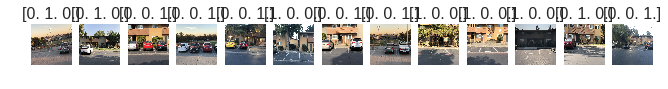

In [0]:
plots(img_test_3,titles=label_test_3)

In [0]:
cm = confusion_matrix(label_t,pre)

Final accuracy: 0.8461538461538461


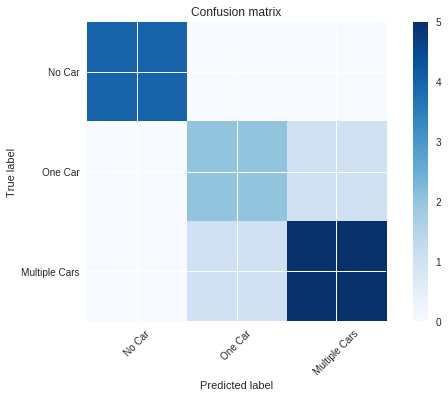

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       0.67      0.67      0.67         3
          2       0.83      0.83      0.83         6

avg / total       0.85      0.85      0.85        13



In [0]:
#accuracy
score = metrics.accuracy_score(label_t, pre)
print("Final accuracy: {}".format(score))

plt.figure()
plot_confusion_matrix(cm,['No Car', 'One Car', 'Multiple Cars'])
plt.show()

print(metrics.classification_report(label_t, pre))

# 2 Categories 

In [0]:
cars_downloaded_2 = drive.CreateFile({'id': '1CzraghJaUPymHVWaUc8jhYNEuLyzQ5ty'})
cars_downloaded_2.GetContentFile('new new cars.zip')

In [0]:
!unzip 'new new cars.zip'

In [0]:
train_path = 'new cars/train'
test_path = 'new cars/test'
validate_path = 'new cars/validate'

**Generating labels from image data**

In [0]:
train_batches = ImageDataGenerator().flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size = 13,
    classes = ['no_car','multiple_cars']
    )

Found 140 images belonging to 2 classes.


In [0]:
validate_batches = ImageDataGenerator().flow_from_directory(
    directory=validate_path,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size = 13,
    classes = ['no_car','multiple_cars']
    )

Found 40 images belonging to 2 classes.


In [0]:
test_batches = ImageDataGenerator().flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    color_mode="rgb",
    #batch_size = 10,
    classes = ['no_car','multiple_cars']
    )

Found 19 images belonging to 2 classes.


In [0]:
img_train,label_train = next(train_batches)

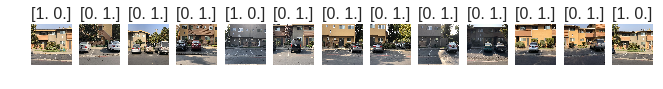

In [0]:
plots(img_train,titles=label_train)

In [0]:
img_test,label_test = next(test_batches)

In [0]:
img_validate,label_validate = next(validate_batches)

In [0]:
img_validate.shape

(13, 224, 224, 3)

## VGG16

**Loading Model**

In [0]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
 
#Load the VGG model
vgg_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)

In [0]:
processed_image_train = vgg16.preprocess_input(img_train)

In [0]:
processed_image_test = vgg16.preprocess_input(img_test)

In [0]:
vgg_model.summary()

**Adding layers of VGG16 model to a new model**

In [0]:
model = Sequential()
for layer in vgg_model.layers:
  model.add(layer)

**Freezing the all layers of new model**

In [0]:
for layer in model.layers:
  layer.trainable = False

In [0]:
vgg_model.output_shape[1:]

(7, 7, 512)

**Adding new layers on top to train**

In [0]:
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

In [0]:
model.summary()

In [0]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit_generator(train_batches,
          steps_per_epoch=11,
          shuffle=True,
          verbose=2,
          validation_data=validate_batches,
          validation_steps=4,
          epochs=5
          )

Epoch 1/5
 - 40s - loss: 4.1750 - acc: 0.6618 - val_loss: 4.2427 - val_acc: 0.6750
Epoch 2/5
 - 31s - loss: 1.4121 - acc: 0.8949 - val_loss: 0.2725 - val_acc: 0.9500
Epoch 3/5
 - 32s - loss: 0.5490 - acc: 0.9611 - val_loss: 0.1599 - val_acc: 0.9250
Epoch 4/5
 - 32s - loss: 0.2019 - acc: 0.9720 - val_loss: 0.1772 - val_acc: 0.9750
Epoch 5/5
 - 31s - loss: 0.2116 - acc: 0.9771 - val_loss: 3.9506e-06 - val_acc: 1.0000


In [0]:
predictions_valid = model.predict(img_test, verbose=2)

In [0]:
predictions_valid

array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.3536034e-27],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.2282458e-27, 1.0000000e+00],
       [1.0000000e+00, 1.3334794e-31],
       [2.7517998e-33, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.0446335e-24],
       [1.0000000e+00, 1.3469381e-27],
       [2.9371060e-02, 9.7062892e-01],
       [1.7957168e-21, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [3.0262708e-21, 1.0000000e+00],
       [1.3077363e-06, 9.9999869e-01],
       [0.0000000e+00, 1.0000000e+00],
       [1.5000866e-27, 1.0000000e+00],
       [3.1801028e-23, 1.0000000e+00],
       [1.2864456e-25, 1.0000000e+00]], dtype=float32)

In [0]:
pre = np.argmax(predictions_valid,axis=1)
pre

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
label_t = np.argmax(label_test,axis=1)
label_t

array([1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
cm = confusion_matrix(label_t,pre)

Final accuracy: 1.0


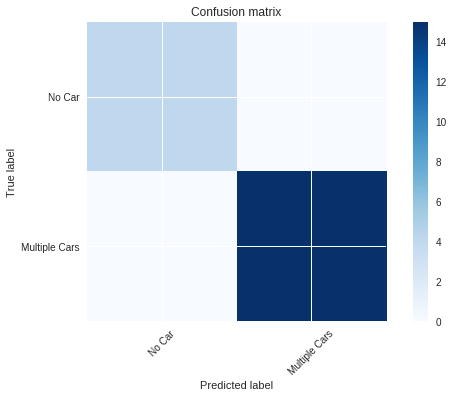

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       1.00      1.00      1.00        15

avg / total       1.00      1.00      1.00        19



In [0]:
#accuracy
score = metrics.accuracy_score(label_t, pre)
print("Final accuracy: {}".format(score))

plt.figure()
plot_confusion_matrix(cm,['No Car','Multiple Cars'])
plt.show()

print(metrics.classification_report(label_t, pre))

## CNN

In [0]:
cnn_model = Sequential([
    Conv2D(1024,(3,3),activation='relu',input_shape=(224,224,3)),
    Flatten(), 
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])

In [0]:
cnn_model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
cnn_model.fit_generator(train_batches,
          steps_per_epoch=11,
          shuffle=True,
          verbose=2,
          validation_data=validate_batches,
          validation_steps=4,
          epochs=5
          )

Epoch 1/5
 - 40s - loss: 4.5788 - acc: 0.7140 - val_loss: 6.8502 - val_acc: 0.5750
Epoch 2/5
 - 31s - loss: 4.4967 - acc: 0.7210 - val_loss: 5.6413 - val_acc: 0.6500
Epoch 3/5
 - 31s - loss: 4.5277 - acc: 0.7191 - val_loss: 7.2531 - val_acc: 0.5500
Epoch 4/5
 - 31s - loss: 4.6915 - acc: 0.7089 - val_loss: 5.2384 - val_acc: 0.6750
Epoch 5/5
 - 31s - loss: 4.8354 - acc: 0.7000 - val_loss: 6.4472 - val_acc: 0.6000


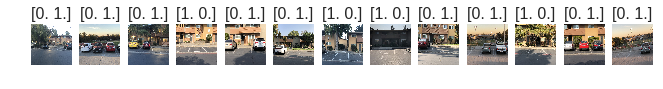

In [0]:
plots(img_test, titles=label_test)

In [0]:
test_label=label_test[:,0]
test_label

array([0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0.], dtype=float32)

In [0]:
predictions_valid = cnn_model.predict_generator(test_batches,steps=1, verbose=0)

In [0]:
predictions_valid[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [0]:
cm = confusion_matrix(label_test[:,0], predictions_valid[:,0])

Final accuracy: 0.7894736842105263


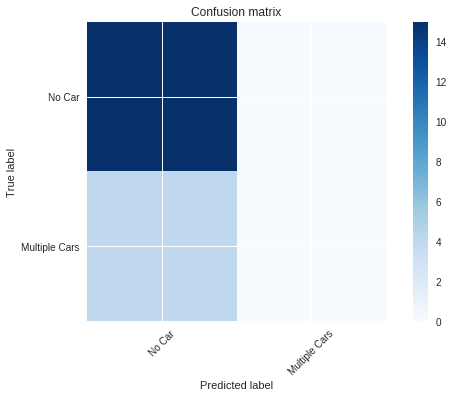

             precision    recall  f1-score   support

        0.0       0.79      1.00      0.88        15
        1.0       0.00      0.00      0.00         4

avg / total       0.62      0.79      0.70        19



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
#accuracy
score = metrics.accuracy_score(label_test[:,0], predictions_valid[:,0])
print("Final accuracy: {}".format(score))

plt.figure()
plot_confusion_matrix(cm,['No Car','Multiple Cars'])
plt.show()

print(metrics.classification_report(label_test[:,0], predictions_valid[:,0]))

## Inception

**Loading the InceptionV3 Model, adding top layers and freezing the layers in base_model**

In [0]:
base_model = keras.applications.inception_v3.InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1129 (Conv2D)            (None, None, None, 3 864         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1129 (Batch (None, None, None, 3 96          conv2d_1129[0][0]                
__________________________________________________________________________________________________
activation_1129 (Activation)    (None, None, None, 3 0           batch_normalization_1129[0][0]   
__________________________________________________________________________________________________
conv2d_113

In [0]:
for layer in model.layers:
    print(layer, layer.trainable)

In [0]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit_generator(train_batches,
          steps_per_epoch=11,
          shuffle=True,
          verbose=2,
          validation_data=validate_batches,
          validation_steps=4,
          epochs=10
          )

Epoch 1/10
 - 79s - loss: 0.8363 - acc: 0.5630 - val_loss: 6.1519 - val_acc: 0.5750
Epoch 2/10
 - 29s - loss: 0.5380 - acc: 0.7350 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 3/10
 - 34s - loss: 0.5125 - acc: 0.7841 - val_loss: 6.1510 - val_acc: 0.5750
Epoch 4/10
 - 34s - loss: 0.4384 - acc: 0.7701 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 5/10
 - 34s - loss: 0.3745 - acc: 0.8701 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 6/10
 - 34s - loss: 0.2916 - acc: 0.8879 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 7/10
 - 34s - loss: 0.2709 - acc: 0.9089 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 8/10
 - 34s - loss: 0.1938 - acc: 0.9560 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 9/10
 - 34s - loss: 0.1797 - acc: 0.9242 - val_loss: 6.0443 - val_acc: 0.6250
Epoch 10/10
 - 34s - loss: 0.2248 - acc: 0.9261 - val_loss: 6.0443 - val_acc: 0.6250


In [0]:
predictions_valid = model.predict(img_test, verbose=2)

In [0]:
model_inc = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(299,299,3), pooling=None, classes=1000)

In [0]:
model_inc.summary()

In [0]:
inception = Sequential()
for layer in model_inc.layers:
  inception.add(layer)

In [0]:
for layer in inception.layers:
  layer.trainable = False

In [0]:
inception.output_shape[1:]

(7, 7, 512)

In [0]:

inception.add(Flatten(input_shape=inception.output_shape[1:]))
inception.add(Dense(256, activation='relu'))
inception.add(Dropout(0.5))
inception.add(Dense(2, activation='softmax'))

In [0]:
inception.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
inception.fit_generator(train_batches,
          steps_per_epoch=11,
          shuffle=True,
          verbose=2,
          validation_data=validate_batches,
          validation_steps=4,
          epochs=10
          )

Epoch 1/5
 - 40s - loss: 4.1750 - acc: 0.6618 - val_loss: 4.2427 - val_acc: 0.6750
Epoch 2/5
 - 31s - loss: 1.4121 - acc: 0.8949 - val_loss: 0.2725 - val_acc: 0.9500
Epoch 3/5
 - 32s - loss: 0.5490 - acc: 0.9611 - val_loss: 0.1599 - val_acc: 0.9250
Epoch 4/5
 - 32s - loss: 0.2019 - acc: 0.9720 - val_loss: 0.1772 - val_acc: 0.9750
Epoch 5/5
 - 31s - loss: 0.2116 - acc: 0.9771 - val_loss: 3.9506e-06 - val_acc: 1.0000


In [0]:
predictions_valid = inception.predict(img_test, verbose=2)

In [0]:
predictions_valid

array([[0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.5766729e-33, 1.0000000e+00],
       [1.7487157e-34, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.1111638e-37, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.3875798e-32, 1.0000000e+00],
       [1.4517823e-36, 1.0000000e+00],
       [7.4428078e-37, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [5.5726663e-28, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [7.7792804e-38, 1.0000000e+00],
       [2.1526801e-27, 1.0000000e+00],
       [5.5235471e-27, 1.0000000e+00],
       [1.8481860e-37, 1.0000000e+00]], dtype=float32)

In [0]:
pre = np.argmax(predictions_valid,axis=1)
pre

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [0]:
label_t = np.argmax(label_test,axis=1)
label_t

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [0]:
cm = confusion_matrix(label_t,pre)

Final accuracy: 0.7894736842105263


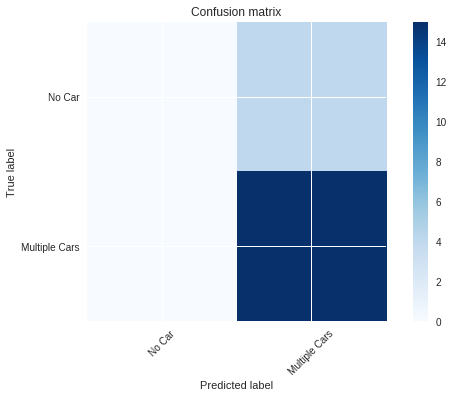

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.79      1.00      0.88        15

avg / total       0.62      0.79      0.70        19



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
#accuracy
score = metrics.accuracy_score(label_t, pre)
print("Final accuracy: {}".format(score))

plt.figure()
plot_confusion_matrix(cm,['No Car','Multiple Cars'])
plt.show()

print(metrics.classification_report(label_t, pre))